# Entity Matching

This notebook focuses on the entity matching process, which involves comparing and matching products from retailer A and retailer B. The steps in this notebook for development will include:

* Preprocess and tokenize the title text from products in both retailer A and retailer B.
* Creating TF-IDF matrices for the tokenized text data. These matrices are crucial for measuring text similarity.
* Computing cosine similarities using the TF-IDF matrices to assess the similarity between the titles of products from both retailers.

The primary goal is to generate a DataFrame containing columns for `titleA`, `titleB`, and `Similarity` scores. This DataFrame facilitates the entity matching process, helping identify matching products between the two retailers.

As part of this notebook, we will also develop reusable functions such as `../tfidf_generation/generate_tfidf_matrix` and `../cosine_similarity/compute_cosine_similarities` to incorporate them seamlessly into the entity matching pipeline steps. These functions will enhance the modularity and maintainability of the entity matching process.

#### Installing necessary libraries

```python
pip install sklearn
```

### Setting up paths for function imports

In [1]:
import sys
sys.path.insert(0, '../scripts/')

In [2]:
# Imports for entity matching
import pandas as pd
from text_tokenization import tokenizeText
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
retA_data_tokens = pd.read_csv('../data/processed/retailerA_tokens.csv') # Retailer A data with titles and tokens
retB_data_tokens = pd.read_csv('../data/processed/retailerB_tokens.csv') # Retailer B data with titles and tokens
combined_data_tokens = pd.read_csv('../data/processed/combined_data_tokens.csv') # Combined data with titles and tokens

## Vectorizer Configuration

In this step, we will configure the vectorizer using the `sklearn.feature_extraction.text` TfidfVectorizer, which will incorporate the `tokenizeText` tokenizer function. Yhis is a class in the scikit-learn library that converts a collection of raw documents into a matrix of TF-IDF features. TF-IDF stands for Term Frequency-Inverse Document Frequency, a common algorithm for transforming text into a meaningful representation of numbers which is used for various tasks in text classification.

As a base vectorizer, we will include the default parameters for the TF-IDF representation but will include the option to modify this parameters based on user input in development. Here's a summary of the main parameters of `TfidfVectorizer` and their default values as of scikit-learn version 0.24:

1. **`input`**: The type of input expected. Default is `'content'`.

2. **`encoding`**: The encoding to use when reading the input. Default is `'utf-8'`.

3. **`decode_error`**: Strategy to use when encountering a decoding error. Default is `'strict'`.

4. **`strip_accents`**: Remove accents during preprocessing. Default is `None`, which means no strip.

5. **`lowercase`**: Convert all characters to lowercase before tokenizing. Default is `True`.

6. **`preprocessor`**: Custom preprocessor. Default is `None`.

7. **`tokenizer`**: Custom tokenizer. Default is `None`.

8. **`analyzer`**: Feature extraction method. Default is `'word'`.

9. **`stop_words`**: Words to be ignored. Default is `None`.

10. **`token_pattern`**: Regular expression denoting what constitutes a “token.” Default is `r"(?u)\b\w\w+\b"`.

11. **`ngram_range`**: The lower and upper boundary of the n-grams to be extracted. Default is `(1, 1)` (unigrams only).

12. **`max_df`**: Maximum document frequency for the given corpus. Default is `1.0`.

13. **`min_df`**: Minimum document frequency for the given corpus. Default is `1`.

14. **`max_features`**: Maximum number of features to keep. Default is `None`.

15. **`vocabulary`**: A priori vocabulary. Default is `None`.

16. **`binary`**: If `True`, all non-zero term counts are set to 1. Default is `False`.

17. **`dtype`**: Type of the matrix returned by fit_transform() or transform(). Default is `numpy.float64`.

18. **`norm`**: Normalization of the term vectors. Default is `'l2'`.

19. **`use_idf`**: Enable inverse-document-frequency reweighting. Default is `True`.

20. **`smooth_idf`**: Smooth idf weights. Default is `True`.

21. **`sublinear_tf`**: Apply sublinear tf scaling. Default is `False`.

In [4]:
# TF-IDF Vectorization with `tokenizeText` function
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda text: tokenizeText(text, lemmas=False))

In [5]:
# Computing the TF-IDF matrix for entity matching
tfidf_mtx = tfidf_vectorizer.fit_transform(retA_data_tokens['title'].tolist() + retB_data_tokens['title'].tolist())

c:\Users\pablo\.conda\envs\python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [6]:
# Exploring matrix
tfidf_mtx

<2173x3546 sparse matrix of type '<class 'numpy.float64'>'
	with 17737 stored elements in Compressed Sparse Row format>

### Splitting the TF-IDF Matrix into `retA` and `retB`

In [7]:
# Split the TF-IDF representation back into retA and retB
split_index = retA_data_tokens.shape[0]
tfidf_matrix_ret_a = tfidf_mtx[:split_index]
tfidf_matrix_ret_b = tfidf_mtx[split_index:]

## Calculating Cosine Similarities

In this phase, we will calculate cosine similarities using the vectorizer and the `textTokenization` function. The goal is to identify similarities among the titles of products from RetailerA and RetailerB, ultimately yielding a valuable `Similarity` metric for entity matching.

In [8]:
# Compute cosine similarity
cosine_similarities_ab = cosine_similarity(tfidf_matrix_ret_a, tfidf_matrix_ret_b).round(5)
cosine_similarities_ab

array([[0.68573, 0.43722, 0.11023, ..., 0.     , 0.     , 0.     ],
       [0.14555, 0.41767, 0.09378, ..., 0.     , 0.     , 0.     ],
       [0.08776, 0.12116, 0.56652, ..., 0.     , 0.     , 0.     ],
       ...,
       [0.     , 0.     , 0.     , ..., 0.30625, 0.37233, 0.     ],
       [0.     , 0.     , 0.     , ..., 0.3089 , 0.54388, 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.73392]])

### Analyzing Cosine Similarities

In [9]:
# Exploring cosine similarities matrix
print(cosine_similarities_ab.shape)

(1081, 1092)


In [10]:
# Building a dataframe with cosine similarities in records from RetA and RetB based on a threshold
similarities = []
thr = 0.6

for idx, row in enumerate(cosine_similarities_ab):
    # Loop through each row of the cosine similarities matrix
    for col_idx, similarity in enumerate(row):
        # Loop through each element in the row
        if similarity > thr:  # Threshold adjusted for a 60% of similarity
            similarities.append((retA_data_tokens.iloc[idx]['title'], retB_data_tokens.iloc[col_idx]['title'], similarity))

sim_ab_df = pd.DataFrame(similarities, columns=['Title_retA', 'Title_retB', 'Similarity'])

sim_ab_df['Similarity'] = sim_ab_df['Similarity'].round(5) # Create `similarity` column
sim_ab_df.to_csv('../data/entity-matching/RetA_RetB_similarities.csv') # Save the dataframe for later usage

In [11]:
# Exploring the dataframe
sim_ab_df.head()

,Title_retA,Title_retB,Similarity
0,Linksys EtherFast 8-Port 10/100 Switch - EZXS88W,Linksys EtherFast EZXS88W Ethernet Switch - EZ...,0.68573
1,Belkin F3H982-10 Pro Series High Integrity 10 ...,Belkin Pro Series High Integrity VGA/SVGA Moni...,0.67453
2,LaCie USB 2.0 Floppy Disk Drive - 706018,LaCie Pocket Floppy Disk Drive - 706018,0.77309
3,Canon KP-36IP Color Ink & Paper Set - 7737A001,Canon KP 36IP Print Cartridge / Paper Kit - 77...,0.68089
4,Kensington Orbit Optical Trackball Mouse - 64327,Kensington Orbit Optical Trackball - USB w/PS2...,0.76323


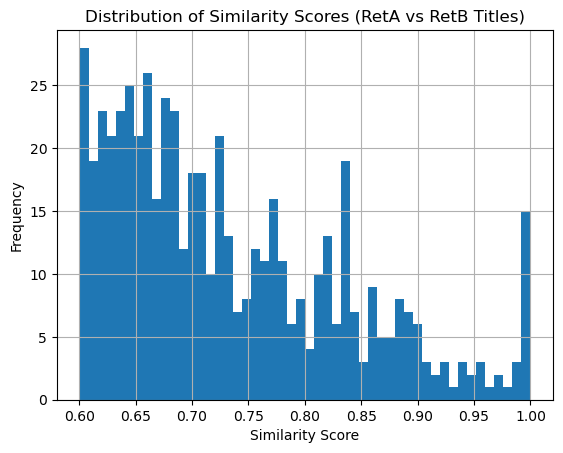

In [12]:
# Plotting the distribution of similarity scores
sim_ab_df['Similarity'].hist(bins=50)
plt.title('Distribution of Similarity Scores (RetA vs RetB Titles)')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Displaying some high similarity pairs (greter than 80%)
high_similarity_pairs = sim_ab_df[sim_ab_df['Similarity'] > 0.8]
high_similarity_pairs[['Title_retA', 'Title_retB']].head(20)

,Title_retA,Title_retB
6,Linksys Wireless-G Ethernet Bridge - WET54G,Linksys G Wireless-G WET54G Wireless Bridge
8,Tripp-Lite PV375 PowerVerter 375-Watt Ultra-Co...,Tripp Lite PowerVerter 375-Watt Ultra-Compact ...
13,Linksys Wireless-G Range Expander - WRE54G,Linksys Wireless-G Range Expander Wireless Bri...
14,Sony VAIO Neoprene Notebook With AC Adapter Ca...,Sony VAIO Notebook and AC Adapter Case - VGPAMC2
16,Netgear RangeMax Wireless Access Point - White...,Netgear RangeMax WPN802 Wireless Access Point ...
17,NetGear ProSafe 24 Port Smart Switch - FS726TP,Netgear ProSafe FS726TP 24 Port 10/100 Smart S...
26,Sanus 13' - 30' Flat Panel TV Black Wall Mount...,Sanus Flat Panel TV Wall Mount - VM1B
30,Canon CB-2LV Battery Charger - 9764A001,Canon CB-2LV Battery Charger - 9764A001
33,Sanus 15' - 40' Flat Panel TV Silver Wall Moun...,Sanus Flat Panel TV Wall Mount - VM400S
35,Sanus 15' - 40' Flat Panel TV Black Wall Mount...,Sanus Flat Panel TV Wall Mount - VM400B


----

### **AI tool usage for this notebook**

#### ChatGPT 3.5
* Improving markdown annotations and function doctrings

#### ChatGPT 4
* Variable naming
* Setting up the path for package calling
* Help with sklearn.feature_extraction.text.TfidfVectorize documentation